If you've tried OpenAI's Completions API for using LLMs to autocomplete some prompt for a task, you'll know that a large part of getting it to work as expected is to have a do a lot of prompt engineering and have a prompt that works really well for your use case. But, while iterating on the prompt, you tend to overrite the previous one or maybe store good ones in a library of sort in a spreadsheet.

*PromptStash helps you keep track of every version of your prompt, that you can retrieve at a later date, hand off to your developer, or even use right in your app for A/B testing.*

**About this tutorial:**
In this tutorial, we'll iterate on a toy use case to translate English to Japanese using OpenAI's Completions API. While doing so, we'll iterate on the prompt template. To do this we'll manage PromptOps - the end-to-end lifecycle of a prompt - with PromptStash:
- We'll first create a Prompt Template, and try it out with OpenAI's Completion API.
- Next, we'll stash it using AI Hero's PromptStash and see how to retrieve it.
- We'll iterate on the prompt a few times.
- Next then create a Test Suite for evaluating the prompt.
- We'll also go over some best practices on how to ship your prompts.
- Bonus:
  - We'll highlight some gotchas and best practices for you to iterate faster.
  - We'll also provide code that's handy for you to add prompt tracing to your application, so you can see how every prompt goes.



Let's first install some libraries we'll need. You might want to restart your notebook if these installs we not found.

In [1]:
%pip install openai aihero python-dotenv
%pip install emoji --upgrade

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## Use Case: Translating English to Japanese to talk with a friend using OpenAI's Completions API.

For this tutorial, let's say we want to talk to our friend, who speaks Japanese! We'll create a prompt template that converts english to Japanese.

### Set up OpenAI

1. We will also use the dotenv library so that we can load the API keys from a .env file instead of storing our env files in code.

    So, first, create a `.env` file right beside this notebook and add your OpenAI API Key to it.
    ```
    OPENAI_API_KEY="YOUR OPENAI API KEY"
    ```

In [2]:
# Load the environment vars from a .env file
import os
import dotenv
dotenv.load_dotenv('.env')

assert "OPENAI_API_KEY" in os.environ, "Please set your OPENAI_API_KEY in a .env file."

2. Let's initialize our OpenAI client using the API key and Organization ID from their [documentation](https://platform.openai.com/docs/introduction).

In [3]:
import openai
# Make sure the key from the .env file works.
print(len(openai.Model.list())) 

2


### Creating the first version of your prompt template.

OpenAI's completions API expects a prompt as an input and returns and output. Often times you want to add certain context or variable values inside your prompt. A prompt template is a template for your prompt with a placeholder for your variable. You can then replace this with your variable at run time. (Usually, the variables in the prompt templates are either in Python f-string format or Jinja2)

You can think of the prompt template below as a template of the instructions you want to provide the Large Language Model. The LLM will attempt to "auto-complete" it using the language structures and knowledge it has learnt - in this case language translation.

Note: This is just an example use case 😀 You can change the template below to track it as you like.

In [4]:
TEMPLATE_STR = """Translate the following text into Japanese:
{text}

Translation:"""


print(f"TEMPLATE:\n--------------\n{TEMPLATE_STR}\n----------------")

TEMPLATE:
--------------
Translate the following text into Japanese:
{text}

Translation:
----------------


Before we pass it to OpenAI, we'll need to replace the variables in the template with the text. So, we'll create a helper function to replace it.

In [5]:
def render_prompt_from_template(template:str, text: str) -> str:
  # Pass in the template and text to inject into it.
  # Since the variable is in the prompt using an f-string, we can use the format function to replace it.
  return template.format(text=text).strip()

Let's try it out

In [6]:
text = "Hello! How are you?"
template = TEMPLATE_STR

prompt = render_prompt_from_template(template=template, text=text)

print(f"Prompt:\n--------------\n{prompt}\n----------------")

Prompt:
--------------
Translate the following text into Japanese:
Hello! How are you?

Translation:
----------------


I think that works great!

We'll also create a helper function that initializes OpenAI client, and can get the completeion of the prompt.

In [7]:
MODEL = "text-davinci-003"
MAX_TOKENS = 250
TEMPERATURE = 0

In [8]:
def complete(prompt:str)->str:
  response = openai.Completion.create(
    model=MODEL,
    prompt=prompt.strip(),
    max_tokens=MAX_TOKENS,
    temperature=TEMPERATURE
  )
  return response["choices"][0]["text"].strip()

Let's test it out with our prompt!

In [9]:
completion = complete(prompt)
print(f"Completion:\n--------------\n{completion}\n----------------")

Completion:
--------------
こんにちは！お元気ですか？
----------------


Yatta! Works as expected! We should just create a `translate` function to make it easier.


In [10]:
def translate(template:str, text:str, verbose:bool=False)->str:
  if verbose:
    print(f"English:\n--------------\n{text}\n----------------")
  translation = complete(render_prompt_from_template(template=template, text=text))
  if verbose:
    print(f"Japanese:\n--------------\n{translation}\n----------------")
  return translation

In [11]:
translation = translate(template=TEMPLATE_STR, text="Hello! My name is Rahul, How are you?", verbose=True)

English:
--------------
Hello! My name is Rahul, How are you?
----------------
Japanese:
--------------
こんにちは！私の名前はラフールです、お元気ですか？
----------------


This looks great! Let's see what your friend thinks.

## Iterating on your Prompt.

You get super excited and start chatting with your friend in Japanese. She loves it!! But she has some feedback - she says it sounds a little formal and you want to use a more comfortable form of Japanese - Japanese has a form you use for polite / formal conversations and then one you use with your friends you know well.

We'll need to change our prompt template for this.

Before we do that, we want to make sure we don't forget our first prompt template. Typically, while iterating on your prompt, you can go to the string and edit it - but that's not a good idea - if your new prompt sucks, how do you go back? Undo? Hmm, what about that prompt template from two weeks ago that worked really well?

This is where PromptStash comes in.

### Installing AI Hero

1. You'll also need to sign in into [AI Hero](https://app.aihero.studio) and create a project (we'll have a default one ready for you.)


2. Go to the PromptStash tool inside your project.
    Once inside PromptStash, you'll see your initialization code with the Project ID and your API Key for that project. Copy the project ID and the api key into the `.env` file. 

    ```
    AI_HERO_PROJECT_ID="YOUR PROJECT ID"
    AI_HERO_PROJECT_API_KEY="YOUR PROJECT API KEY"
    ```

In [12]:
import os
from aihero import promptstash

ps = promptstash(project_id=os.environ["AI_HERO_PROJECT_ID"], api_key=os.environ["AI_HERO_PROJECT_API_KEY"])


### Stashing your Old Prompt
So, we will first stash our template using PromptStash. You might want to give your template a good identifier (e.g. `english-to-japanese`) so that it's easier to track it as you iterate.


In [13]:
TEMPLATE_ID = "english-to-japanese"

variant = ps.stash_template(template_id=TEMPLATE_ID, body=template)
print(f"Prompt variant: {variant}")

Prompt variant: ddf1da39297aedad42421a57a0c8c220


In [14]:
stored_template = ps.variant(template_id=TEMPLATE_ID, variant=variant)

print(f"Stored Template:\n--------------\n{stored_template}\n----------------")

Stored Template:
--------------
Translate the following text into Japanese:
{text}

Translation:
----------------


 You can see this in the PromptStash UI in AI Hero!

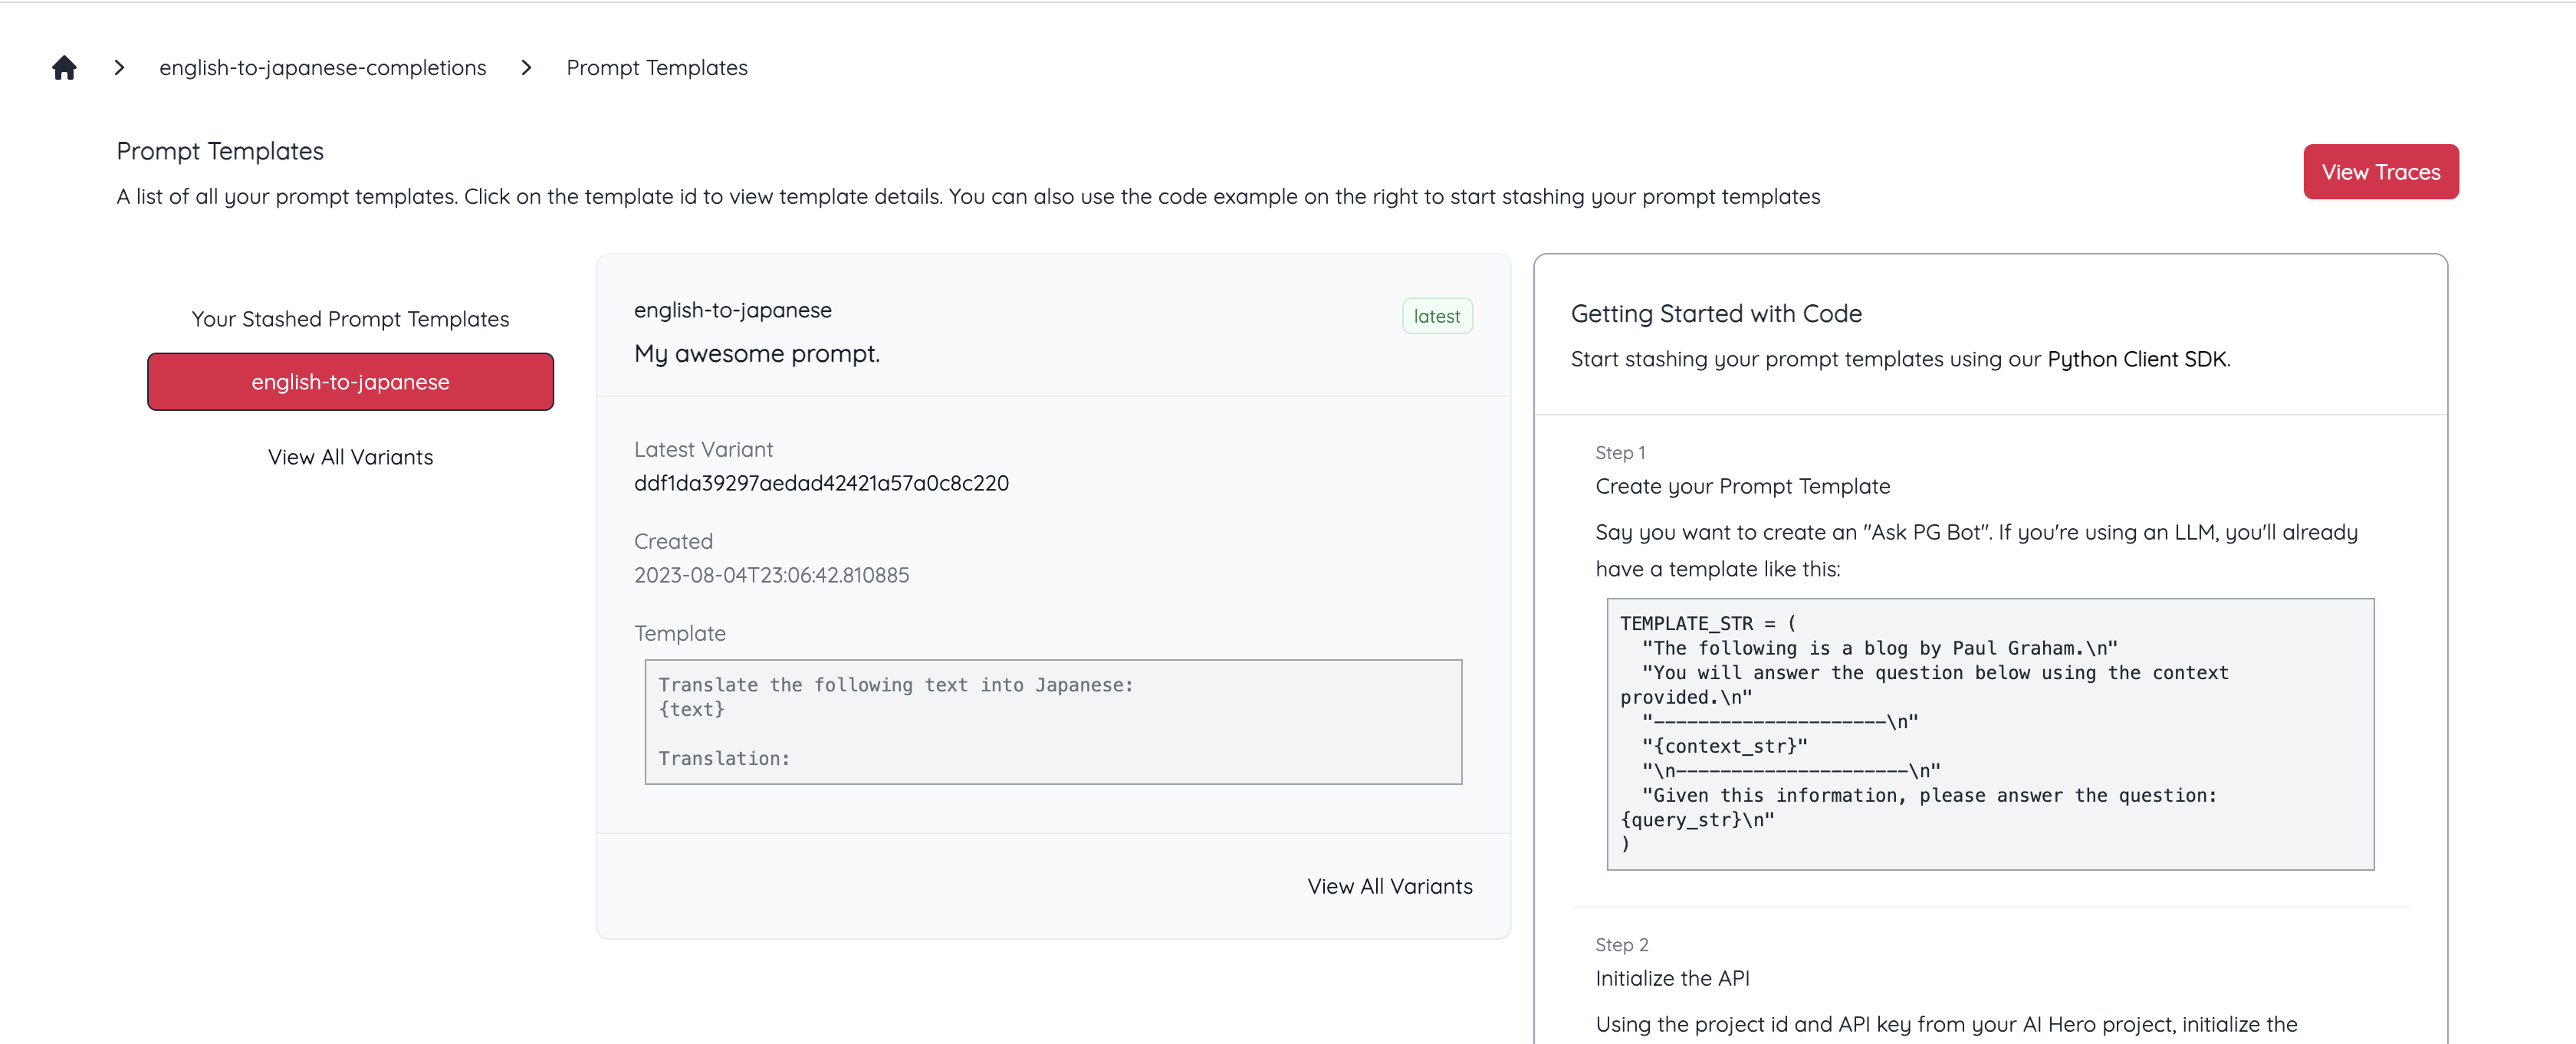

### Your first iteration - making the translation sound casual.

To iterate based on your friend's feedback, let's create a new version of the prompt and stash it.

In [15]:
casual_template = """Translate the following text into Japanese. Use a casual
tone that is used while talking with a friend.
Text:{text}

Translation:"""

casual_variant = ps.stash_template(template_id=TEMPLATE_ID, body=casual_template)
print(f"Prompt variant: {casual_variant}")

Prompt variant: b1954de9ed4dbe31197a15431a7d1e82


You can see the stashed prompt in the UI.

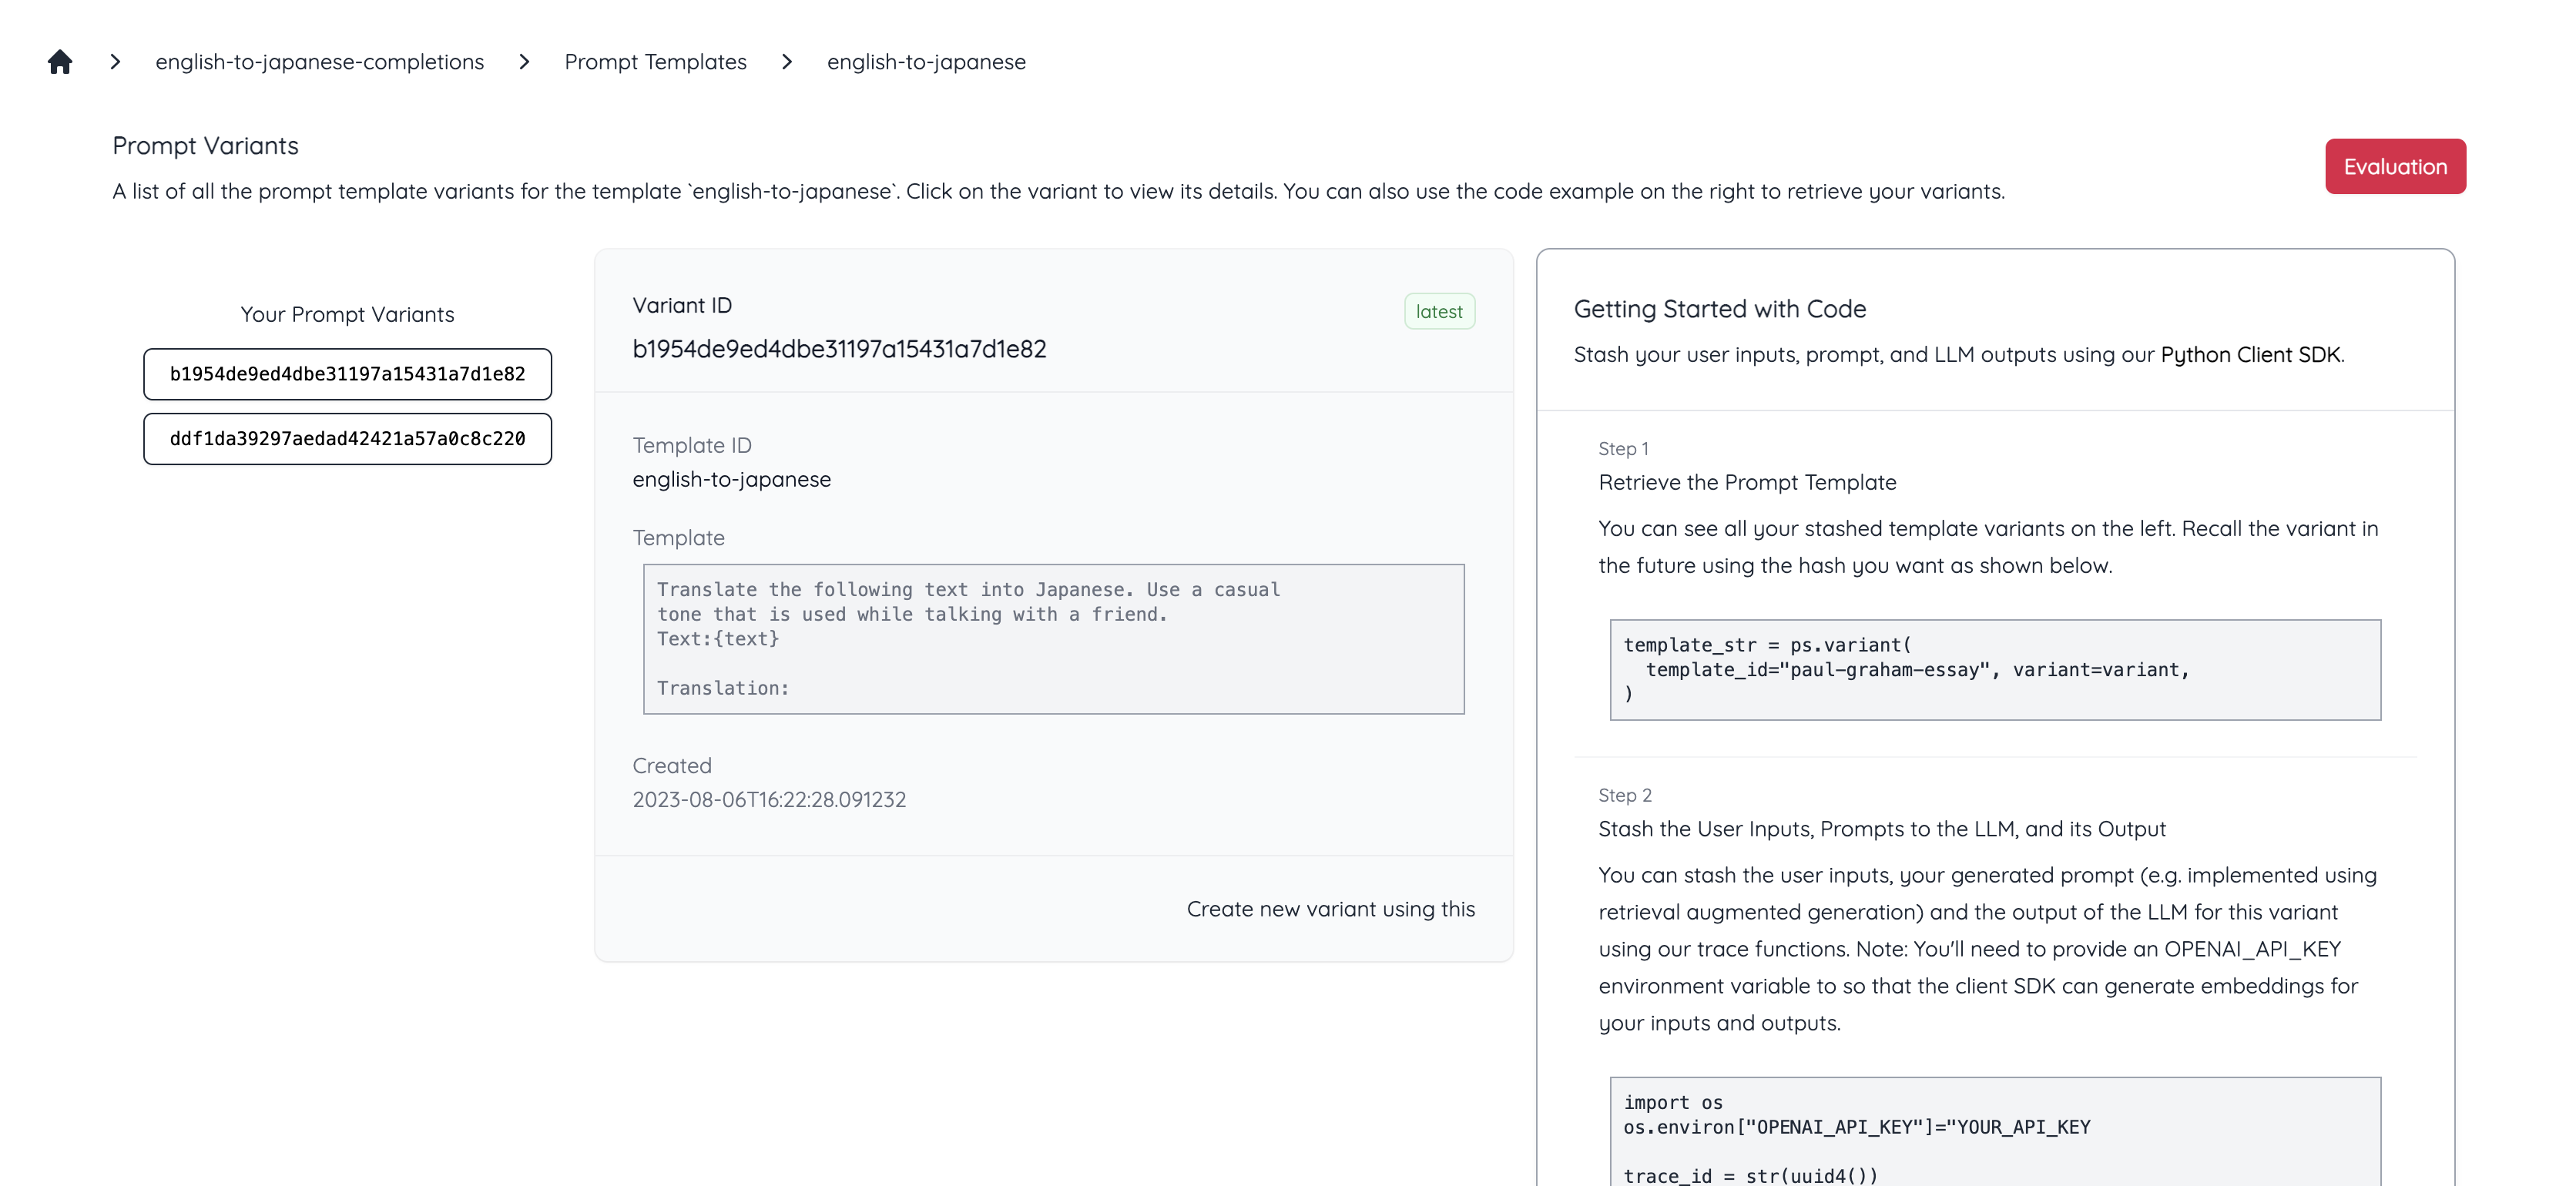

In [16]:
translation = translate(template=casual_template, text="Hello! My name is Rahul, How are you?", verbose=True)

English:
--------------
Hello! My name is Rahul, How are you?
----------------
Japanese:
--------------
やあ！私の名前はラフールだよ、元気？
----------------


Your friend thinks that's great! As you start chatting you realize you want a few more features:
- You want to use an emoji at the end to convey your emotion.
- You also want to be able to say it out. You you want a pronounciation guide in english right beside it.

### More iterations

In [17]:
helper_template = """Translate the following text into Japanese. Use a casual \
tone that is used while talking with a friend. You will end each line with an \
emoji that shows the emotions of the text. After the translation in the next line, \
return a guide to pronounce the Japanese text in English.
Text: {text}

Translation:"""

helper_variant = ps.stash_template(template_id=TEMPLATE_ID, body=helper_template)
print(f"Prompt variant: {helper_variant}")

Prompt variant: 523059eac0436cab9739413e8779959d


In [18]:
translation = translate(template=helper_template, text="Hello! My name is Rahul, How are you?", verbose=True)

English:
--------------
Hello! My name is Rahul, How are you?
----------------
Japanese:
--------------
こんにちは！私の名前はラーフです、お元気ですか？😊
Pronunciation Guide: Konnichiwa! Watashi no namae wa Raafu desu, ogenki desu ka?
----------------


Well, now that you have a working prompt, let's make sure it's robust. We'll create a test suite with different test cases and test out the prompt. You can find the starter code in the evaluation prompt.

With PromptStash, there are two types of tests:
- `test_*`: Execute the Python function. Implement as needed and assert as needed.
- `ask_*`: Evaluate using GPT3.5-turbo (Note: doesn't work the best yet.) Note: You'll need to provide an OPENAI_API_KEY environment variable to so that the client SDK can generate embeddings for your inputs and outputs.

IMP: The use of your OPENAI_API_KEY would incur charges towards your OpenAI account, and we recommend you set limits on your account with OpenAI

In [19]:
import emoji
from aihero.eval import PromptTestSuite

class TranslatorBotTests(PromptTestSuite):
    def ask_is_japanese(self) -> str:
        return "Does the text contain Japanese?"

    def test_has_pronounciation_guide(self, output):
        assert "pronounciation:" in output.lower() or "pronunciation guide:" in output.lower(), "The output doesn't contain a pronounciation guide."
        
    def test_has_emoji(self, output):
        assert emoji.emoji_count(output) > 0, "The output doesn't contain any emoji."

    def ask_is_casual(self) -> str:
        return "Is the text in japanese using casual form (i.e. suitable for friends)?"

TEST_TEMPLATE_ID = "english-to-japanese-test"

ts = ps.build_test_suite(
  test_suite_id=TEST_TEMPLATE_ID,
  test_suite_cls=TranslatorBotTests
)

We'll create a few test cases:

In [20]:
TEST_CASES = [
    "Hi! What's up?",
    "What are you up to?",
    "I'm hungry! What should I eat?",
    "Do you want to hang out?",
    "OMG! Did you hear the latest BTS song?"
]

# Note: If you have a longer list, these can come from a csv file.

In [21]:
import time
from datetime import date

# We'll store the results and the time it takes into a list so that we can run the test suite on it.
times = []
completions = []
for test_case in TEST_CASES:
    tic = time.perf_counter()
    translation = translate(template=helper_template, text=test_case, verbose=True)
    toc = time.perf_counter()
    times.append(toc - tic)

    # Since our tests will run against the prompt, input and output, we'll create the right texts.
    prompt = helper_template.format(text=test_case)
    completions.append(
        {
            "inputs": {"text": test_case},
            "rendered_inputs": f"English: {test_case}",
            "prompt": prompt,
            "output": translation,
        }
    )
    print() # Newline to separte test cases.

# Next, we calculate the average time taken, and run the test suite on our test cases.
avg_time = sum(times) / len(times)

ts.run(
    template_id=TEMPLATE_ID,
    variant=helper_variant,
    completions=completions,
    model={"name": MODEL, "version": date.today().strftime("%Y-%m-%d")},
    metrics={"times": times, "avg_time": avg_time},
    other={"embedding_model": "text-embedding-ada-002"},
)

English:
--------------
Hi! What's up?
----------------
Japanese:
--------------
こんにちは！どうしたの？😊
Pronunciation: Konnichiwa! Dōshita no?
----------------

English:
--------------
What are you up to?
----------------
Japanese:
--------------
何してるの？😊
Pronunciation: Nani shiteru no?
----------------

English:
--------------
I'm hungry! What should I eat?
----------------
Japanese:
--------------
私はお腹が空いてる！何を食べよう？🤔
Pronunciation Guide: Watashi wa onaka ga suitaeru! Nani o tabeyou? 🤔
----------------

English:
--------------
Do you want to hang out?
----------------
Japanese:
--------------
今夜遊びに行く？😊
Pronunciation Guide: Konya asobi ni iku?
----------------

English:
--------------
OMG! Did you hear the latest BTS song?
----------------
Japanese:
--------------
うわー！最新のBTSの曲聞いた？🤩
Pronunciation Guide: Uwa-! Saishin no BTS no kyoku kiita? 🤩
----------------

Test Case: 'English: Hi! What's up?'
Running ask_is_casual... PASS
Running ask_is_japanese... PASS
Running test_has_emoji... PASS
Running te

You can also see the details of the test run in the evaluation page on the UI:
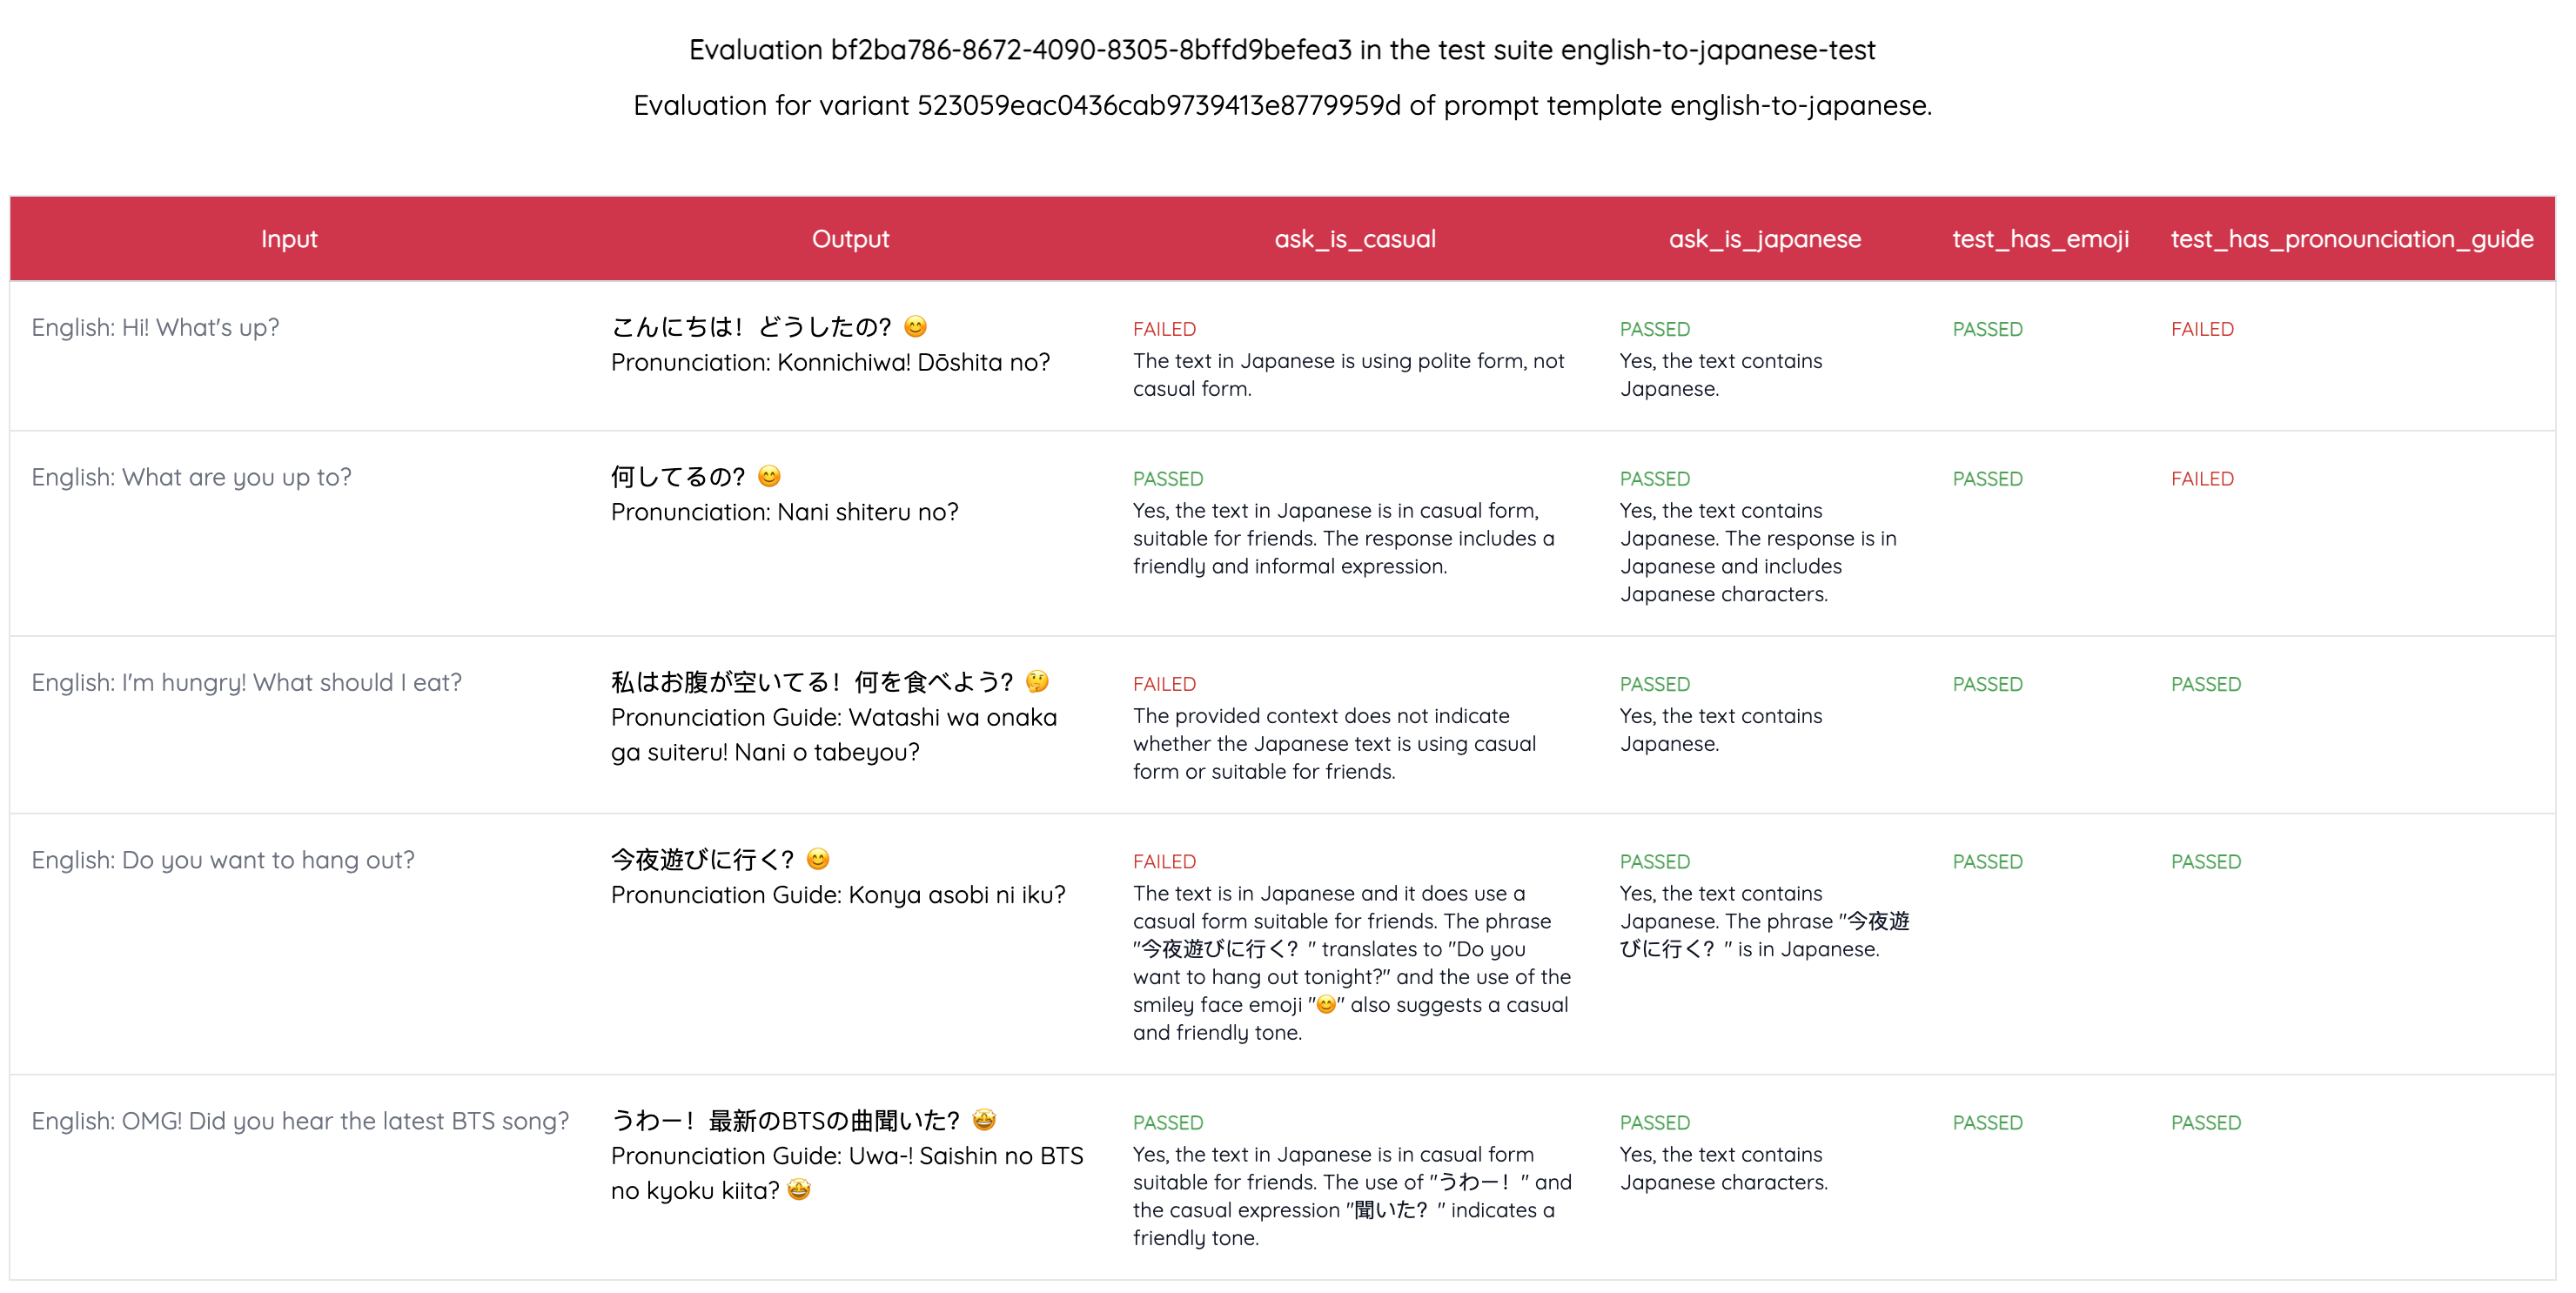

While some of these tests, could be run better, we're all set to start using our translator with our friend!

## Using the variant in production.

Now that you've stashed the prompt and made sure it works, you might want create an app from it. To do so, you might want to retrieve the variant you want, and start using it in production. This code provides a helper class you can use for the variant. 

In [22]:
import os
import openai
import dotenv
from datetime import date
from uuid import uuid4
from aihero import promptstash

MODEL = "text-davinci-003"
MAX_TOKENS = 250
TEMPERATURE = 0

# Load the environment variables
dotenv.load_dotenv()

# Get the API key from the environment
openai.api_key = os.environ["OPENAI_API_KEY"]
ps = promptstash(project_id=os.environ["AI_HERO_PROJECT_ID"], api_key=os.environ["AI_HERO_PROJECT_API_KEY"])

class PromptStashOpenAICompletionsHelper:

    def __init__(self, template_id: str, variant:str):
        self.template_id = template_id
        self.variant = variant
        self.template = ps.variant(template_id, variant)

    def complete(self, inputs, trace_id: str=str(uuid4())):
        prompt = self.template.format(**inputs).strip()
        response = openai.Completion.create(
            model=MODEL,
            prompt=prompt.strip(),
            max_tokens=MAX_TOKENS,
            temperature=TEMPERATURE
        )
        output = response["choices"][0]["text"].strip()
        
        step_id = str(uuid4())

        ps.stash_completion(
            trace_id=trace_id,
            step_id=step_id,
            template_id="paul-graham-essay",
            variant=variant,
            prompt=prompt,
            output=output,
            inputs=inputs,
            rendered_inputs=f"Text: {inputs['text']}",
            model={"name": "openai-davinci-003", "version": date.today().strftime("%Y-%m-%d")},
            metrics={"time": (toc - tic)},
            other={"embedding_model": "text-embedding-ada-002"},
        )
        return output
        

    def feedback(self, trace_id: str, thumbs_up: bool, thumbs_down: bool, correction: str = None):
        step_id = str(uuid4())
        ps.stash_feedback(trace_id=trace_id, step_id=step_id, thumbs_up=thumbs_up, thumbs_down=thumbs_down, correction=correction)


In [27]:
prompt_stash_openai_completions_helper = PromptStashOpenAICompletionsHelper(template_id=TEMPLATE_ID, variant=helper_variant)

text = "You're my best friend!"

print(f"English:\n--------------\n{text}\n----------------")
trace_id = str(uuid4())
translation = prompt_stash_openai_completions_helper.complete(trace_id=trace_id, inputs={"text": text})
print(f"Japanese:\n--------------\n{translation}\n----------------")

English:
--------------
You're my best friend!
----------------
Japanese:
--------------
君は俺の最高の友達だよ！😊
Pronunciation Guide: Kimi wa ore no saikō no tomodachi da yo!
----------------


Prompt stashed.


Pro-tip: 
- Iterate your prompt frequently. 
- Stash every input and outpt. 
- Collect feedback on your prompt when you can:

In [28]:
translation = prompt_stash_openai_completions_helper.feedback(trace_id=trace_id, thumbs_up=True,thumbs_down=False)

Feedback stashed.


You can see your trace for trace_id and all its steps in the UI. 
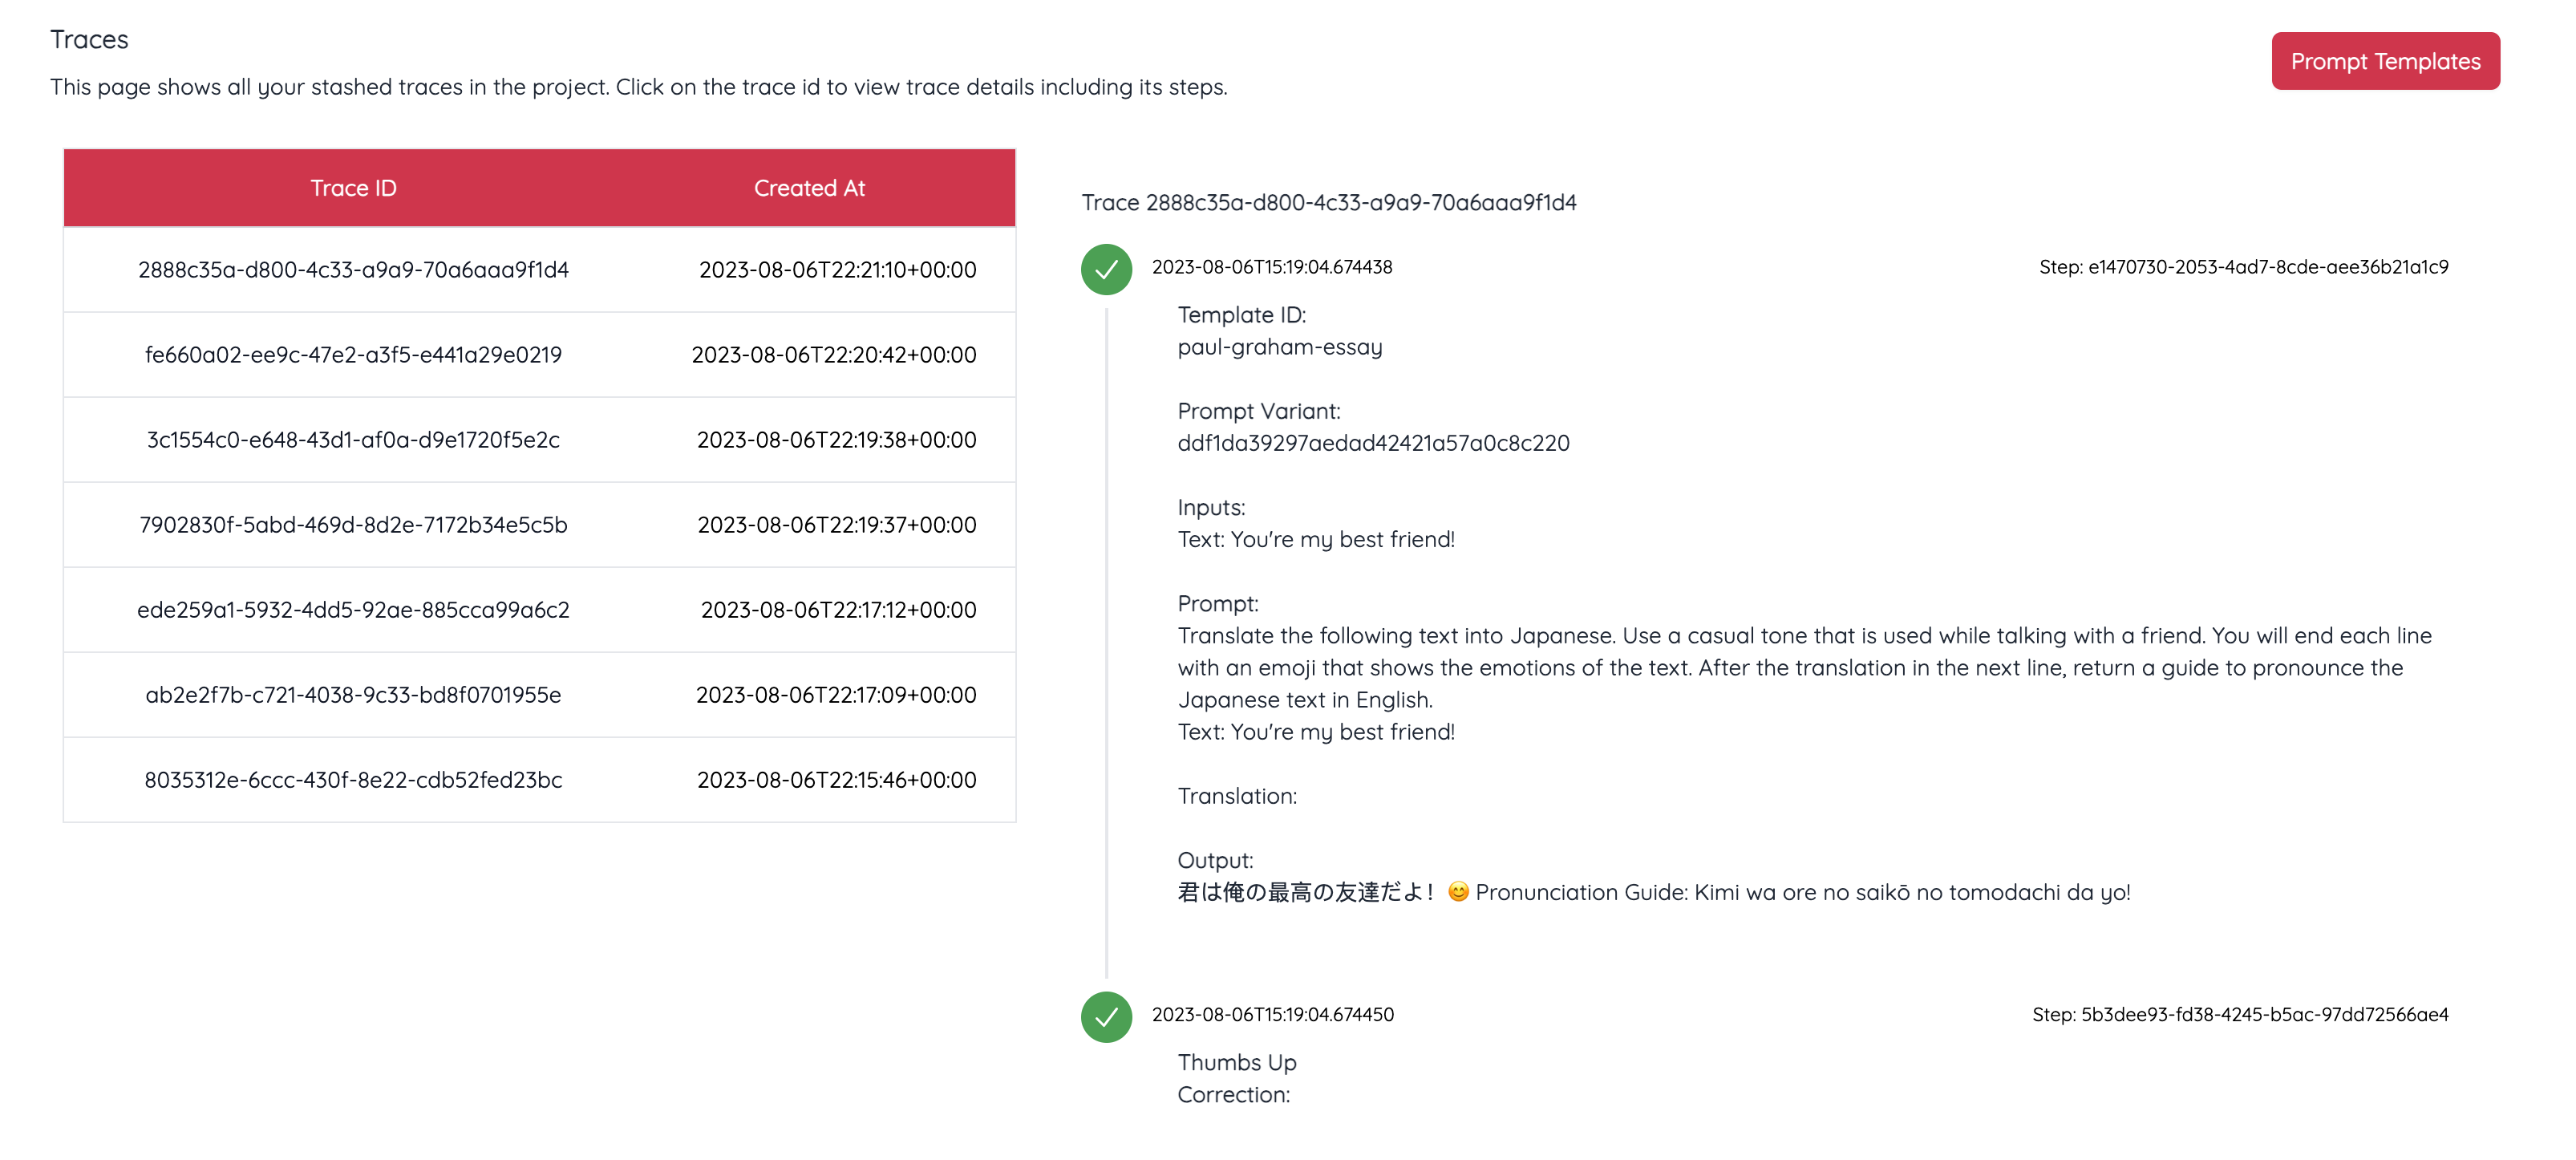

That's it! Have fun trying this with your own prompts! 

**If you have any questions, please email team@aihero.studio!**